In [387]:
import pandas as pd
import json
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


%matplotlib inline

with open('m_rec.json') as data_file:
   data = json.load(data_file)

#pprint(data)


Reading the data into a dataframe

In [388]:
num_records = len(data['Leads'])
print(num_records)

num_columns = len(data['Leads'][0]['LeadPropertyList'])

lead_properties = data['Leads'][0]['LeadPropertyList'][0:num_columns]

column_names = [lead_properties[column]['Attribute'] for column in range(0,num_columns)]

print("Column names for the leads.")
print("=" * 100)
print(column_names)

data_lead = [[data['Leads'][record]['LeadPropertyList'][column]['Value'] for column in range(num_columns)] for record in range(num_records)]

lead_df = pd.DataFrame(columns = column_names, data = data_lead)

print(lead_df.head())

print(lead_df.info())



75136
Column names for the leads.
['ProspectActivityDate_Min', 'Web_Referrer', 'Web_RefKeyword', 'LeadLastModifiedOn', 'ConversionReferrerURL', 'SourceReferrerURL', 'SourceIPAddress', 'Latitude', 'Longitude', 'ProspectID', 'ProspectAutoId', 'ProspectActivityId_Max', 'ProspectActivityId_Min', 'StatusCode', 'StatusReason', 'DeletionStatusCode', 'RelatedProspectId', 'SourceReferrer', 'NotableEvent', 'NotableEventdate', 'LastVisitDate', 'RelatedLandingPageId', 'FirstLandingPageSubmissionId', 'FirstLandingPageSubmissionDate', 'ProspectActivityName_Max', 'ProspectActivityDate_Max', 'FirstName', 'LastName', 'EmailAddress', 'Phone', 'Company', 'Website', 'DoNotTrack', 'DoNotEmail', 'DoNotCall', 'Source', 'Mobile', 'SourceCampaign', 'SourceMedium', 'JobTitle', 'SourceContent', 'Notes', 'Score', 'EngagementScore', 'Revenue', 'ProspectStage', 'QualityScore01', 'OwnerId', 'CreatedBy', 'CreatedByName', 'CreatedOn', 'LeadConversionDate', 'ModifiedBy', 'ModifiedByName', 'ModifiedOn', 'TimeZone', 'Tot

Looking at the dates when leads were created

In [389]:
lead_df['CreatedOn'] = pd.to_datetime(lead_df['CreatedOn'])
least_recent_date = lead_df['CreatedOn'].min()
recent_date = lead_df['CreatedOn'].max()
print("Earliest lead record created: ",least_recent_date)
print("Latest lead record created: ", recent_date)


Earliest lead record created:  2017-09-30 19:15:06
Latest lead record created:  2018-07-31 19:43:35


Number of leads created across the months

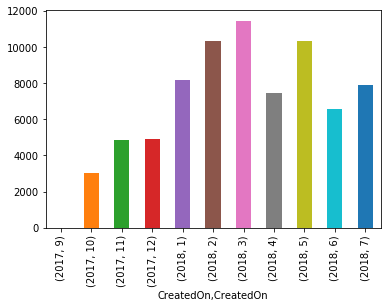

In [390]:


lead_df["CreatedOn"] = lead_df["CreatedOn"].astype("datetime64")
grouped_data = lead_df['ProspectID'].groupby([lead_df["CreatedOn"].dt.year, lead_df["CreatedOn"].dt.month]).count()

grouped_data.plot(kind='bar')


In [391]:
print(len(lead_df['ProspectID'].unique()))

74825


In [392]:
lead_df = lead_df.drop_duplicates()

In [393]:
lead_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74831 entries, 0 to 75135
Columns: 126 entries, ProspectActivityDate_Min to LeadAge
dtypes: datetime64[ns](1), object(125)
memory usage: 72.5+ MB


In [394]:
print(lead_df['StatusCode'].unique())

['0' '1']


In [395]:
stages = list(lead_df['ProspectStage'].unique())
print(stages)

['Engaged Lead', 'Cold', 'Warm Lead', 'Fresh Lead', 'Sale', 'Interested Next Batch', 'Application Link Sent', 'Fresh lead', 'Hot Lead', 'Unusable', 'Usable']


In [396]:
print(lead_df[lead_df['ProspectStage'] == 'Sale'].shape[0])

2902


Combining 'Fresh Lead' and 'Fresh lead' frequencies

In [397]:
stage_freq = [lead_df[lead_df['ProspectStage'] == s].shape[0] for s in stages]
stage_freq[3] += stage_freq[7]
print(stage_freq)
stages = ['Engaged Lead', 'Cold', 'Warm Lead', 'Fresh Lead', 'Sale', 'Interested Next Batch', 'Application Link Sent', 'Hot Lead', 'Unusable', 'Usable']
stage_freq1 = stage_freq[0:7]
stage_freq1.extend(stage_freq[8:12])
print(stages)
print(stage_freq1)
print(len(stages), len(stage_freq1))

[3139, 67068, 89, 1164, 2902, 323, 83, 50, 11, 48, 4]
['Engaged Lead', 'Cold', 'Warm Lead', 'Fresh Lead', 'Sale', 'Interested Next Batch', 'Application Link Sent', 'Hot Lead', 'Unusable', 'Usable']
[3139, 67068, 89, 1164, 2902, 323, 83, 11, 48, 4]
10 10


/home/monica/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:641: UserWarning: Unrecognized location "left center". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


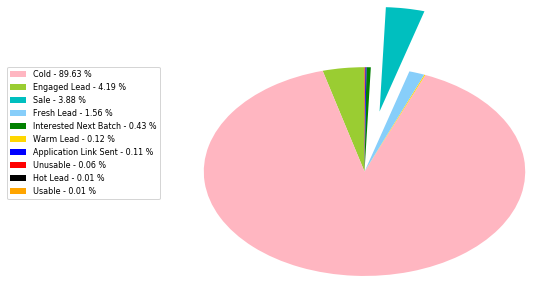

In [398]:


colors = ['yellowgreen','lightpink','gold','lightskyblue','c','green','blue','black', 'red', 'orange']
porcent = [100 * stage_freq1[i]/sum(stage_freq1) for i in range(len(stages))]
explode = (0,0,0,0,0.7,0,0,0,0,0)

patches, texts = plt.pie(stage_freq1, colors=colors, startangle=90, radius=1.2, explode=explode)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(stages, porcent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, stage_freq1),
                                          key=lambda stages: stages[2],
                                          reverse=True))

plt.legend(patches, labels, loc='left center', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)

plt.savefig('piechart.png', bbox_inches='tight')

Ignoring cold leads for now

['Engaged Lead', 'Warm Lead', 'Fresh Lead', 'Sale', 'Interested Next Batch', 'Application Link Sent', 'Hot Lead', 'Unusable', 'Usable'] [3139, 89, 1164, 2902, 323, 83, 11, 48, 4] 9 9
9


/home/monica/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:641: UserWarning: Unrecognized location "left center". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


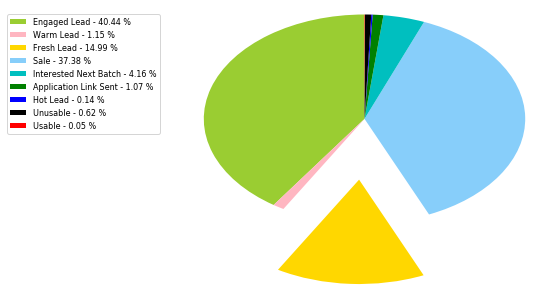

In [399]:
colors = ['yellowgreen','lightpink','gold','lightskyblue','c','green','blue','black', 'red']
stage_freq2 = stage_freq1[2:]
stage_freq2.insert(0, stage_freq1[0])
stages2 = stages[2:]
stages2.insert(0, stages[0])
print(stages2, stage_freq2, len(stages2), len(stage_freq2))
porcent = [100 * stage_freq2[i]/sum(stage_freq2) for i in range(len(stages2))]
explode = (0,0,0.7,0,0,0,0,0,0)
print(len(explode))

patches, texts = plt.pie(stage_freq2, colors=colors, startangle=90, radius=1.2, explode=explode)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(stages2, porcent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, stage_freq2),
                                          key=lambda stages: stages2[2],
                                          reverse=True))

plt.legend(patches, labels, loc='left center', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)



/home/monica/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:641: UserWarning: Unrecognized location "left center". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


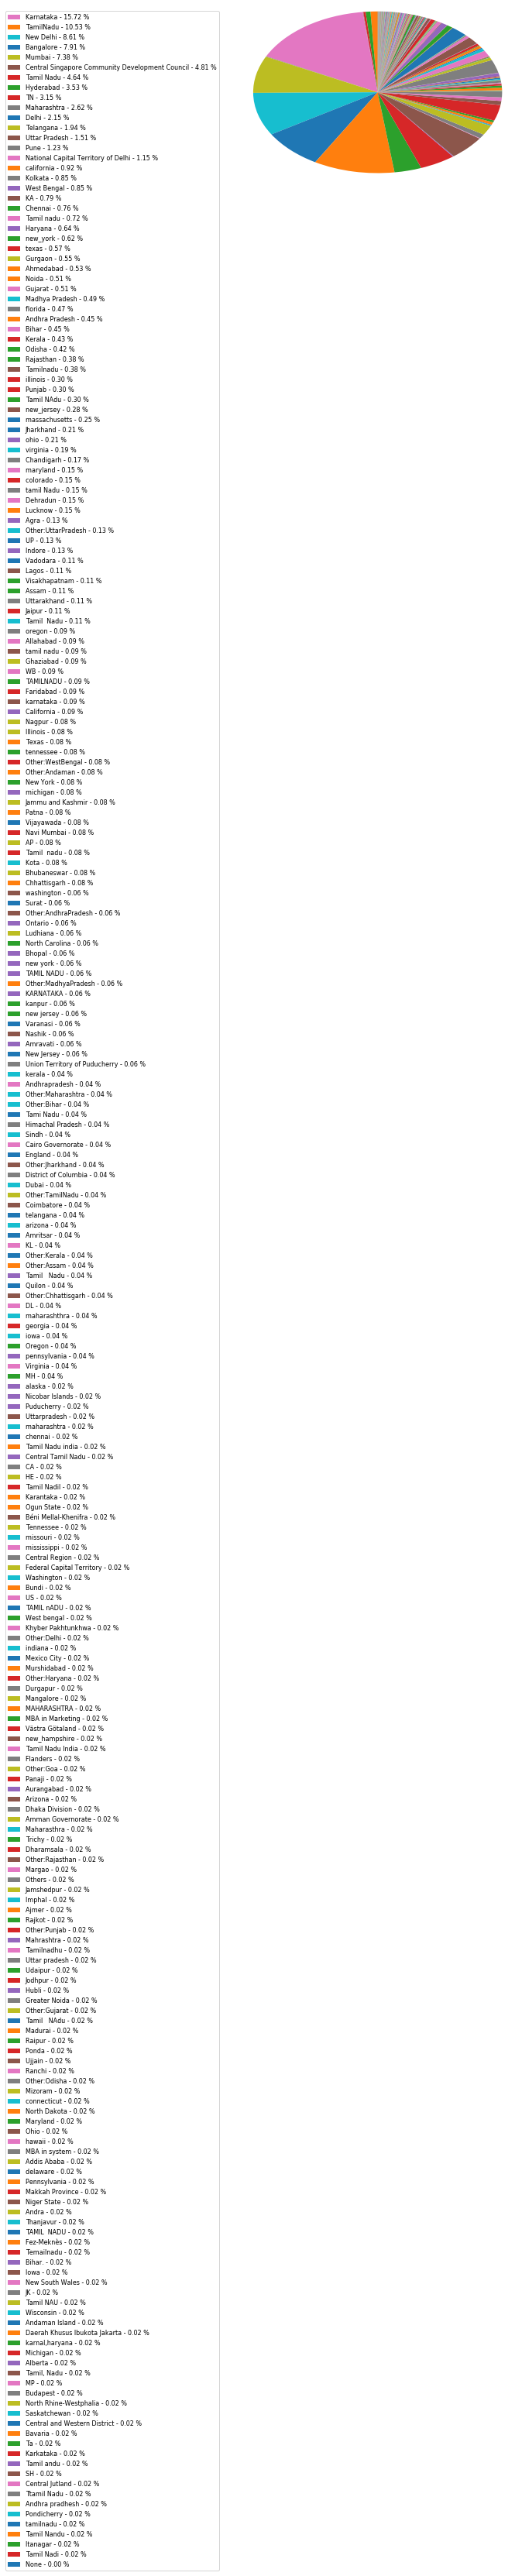

In [400]:
states = list(lead_df['mx_State'].unique())
state_freq = [(lead_df['mx_State'] == state).sum() for state in states]
porcent = [100 * state_freq[i]/sum(state_freq) for i in range(len(states))]

patches, texts = plt.pie(state_freq, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(states, porcent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, state_freq),
                                          key=lambda states: states[2],
                                          reverse=True))

plt.legend(patches, labels, loc='left center', bbox_to_anchor=(-0.1, 1.), fontsize=8)

Looking at the different fields to see if there is a relationship to conversion.

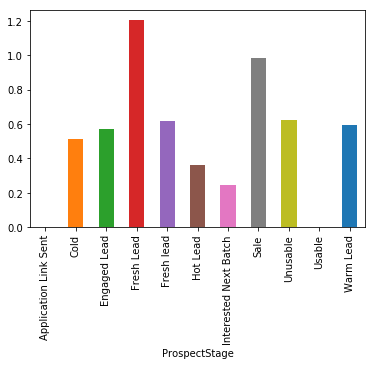

In [401]:
lead_df['Score'] = pd.to_numeric(lead_df['Score'])
grouped_data = lead_df['Score'].groupby([lead_df["ProspectStage"]]).mean()
grouped_data.plot(kind='bar')

Looks like the EngagementScore value for all the leads is 0

['0']
<bound method NDFrame.as_matrix of ProspectStage
Application Link Sent    0
Cold                     0
Engaged Lead             0
Fresh Lead               0
Fresh lead               0
Hot Lead                 0
Interested Next Batch    0
Sale                     0
Unusable                 0
Usable                   0
Warm Lead                0
Name: EngagementScore, dtype: int64>


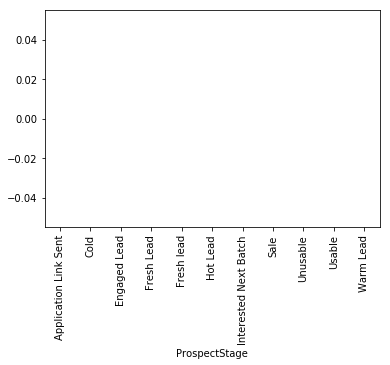

In [402]:
print(lead_df['EngagementScore'].unique())
lead_df['EngagementScore'] = pd.to_numeric(lead_df['EngagementScore'] )
grouped_data = lead_df['EngagementScore'].groupby([lead_df["ProspectStage"]]).mean()
print(grouped_data.as_matrix)
grouped_data.plot(kind='bar', colormap = 'Reds')

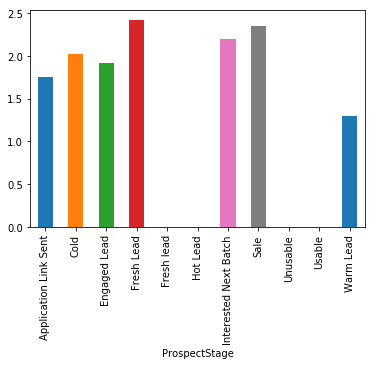

In [403]:
lead_df['QualityScore01'] = pd.to_numeric(lead_df['QualityScore01'] )
grouped_data = lead_df['QualityScore01'].groupby([lead_df["ProspectStage"]]).mean()
grouped_data.plot(kind='bar')

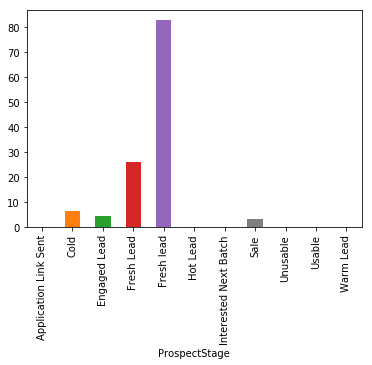

In [404]:
lead_df['AvgTimePerVisit'] = pd.to_numeric(lead_df['AvgTimePerVisit'] )
grouped_data = lead_df['AvgTimePerVisit'].groupby([lead_df["ProspectStage"]]).mean()
grouped_data.plot(kind='bar')

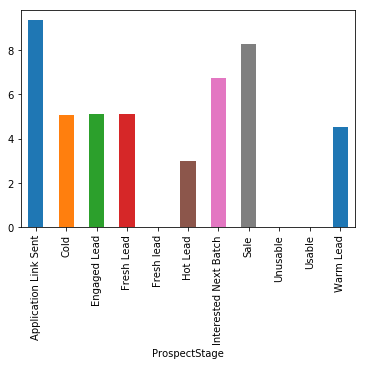

In [405]:
lead_df['mx_Years_of_Experience'] = pd.to_numeric(lead_df['mx_Years_of_Experience'] )
grouped_data = lead_df['mx_Years_of_Experience'].groupby([lead_df["ProspectStage"]]).mean()
grouped_data.plot(kind='bar')

[None '10-15 lac' '6-10 lac' '3-6 lac' '0-3 lac' '20-30 lac' '15-20 lac'
 '30-40 lac' '40+ lac' 'NA']


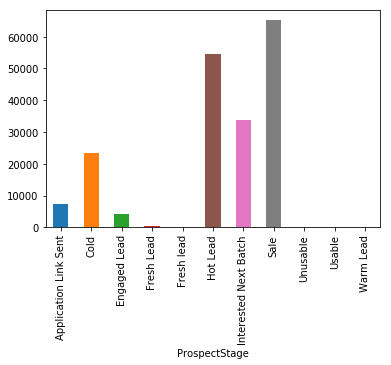

In [406]:
print(lead_df['mx_Salary'].unique())
#Mapping to the higher end of the salary range
lead_df['mx_Salary'] = lead_df['mx_Salary'].map({'10-15 lac': 1500000, '6-10 lac': 1000000,
                                            '3-6 lac': 600000, '0-3 lac': 300000, '20-30 lac': 3000000, '15-20 lac': 2000000,
                                           '30-40 lac': 4000000, '40+ lac': 4500000, 'NA': 0, None: 0})
lead_df['mx_Salary'] = pd.to_numeric(lead_df['mx_Salary'] )
grouped_data = lead_df['mx_Salary'].groupby([lead_df["ProspectStage"]]).mean()
grouped_data.plot(kind='bar')

[None '29' '22-25' '26-30' '18-21' '31-35' '36-40' '40+' '23' '28'
 'less than 9 years' '20' '34' '21' '25' '41' '36' '26' '26 to 32 years'
 '24' '22' '32' '27' '37' '45' '42' '40' '47' '33' '30' '44' '35' '38'
 '46' '39' '64' '55' '59' '31' '43' '17+ years' '62' '60' '48' '49' '65'
 '50' '57' '53' '54' '52' '18' '22 to 25 years' '32 to 40 years'
 '40+ years' '51']
[ 0.   nan 23.5 28.5 19.5 33.  38.  41.  23.  28.   8.  20.  34.  21.
 25.  36.  26.  29.  24.  22.  32.  27.  37.  45.  42.  40.  47.  30.
 44.  35.  46.  39.  64.  55.  59.  31.  43.  18.  62.  60.  48.  49.
 65.  50.  57.  53.  54.  52. ]


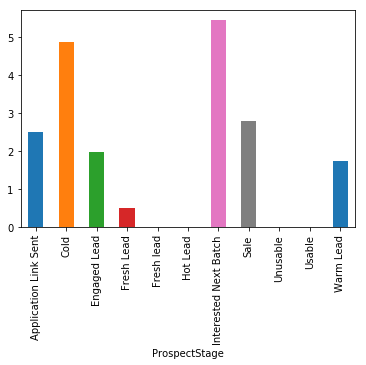

In [407]:
print(lead_df['mx_Age'].unique())

lead_df['mx_Age'] = lead_df['mx_Age'].map(
    {'22-25': 23.5, '26-30': 28.5, '18-21': 19.5, '31-35': 33, '36-40': 38, '40+': 41, \
     '23': 23, '28': 28, '20': 20, '34': 34, '21':21, '25':25, '41':41, '36':36, \
     '26':26, '24': 24, '22':22, '32':32, '27':27, '37':37, '45':45, '42':42, \
     '40': 40, '47':47, '33':33, '30':30, '44':44, '35':35, '38':38, \
     '46': 46, '39': 39, '64':64, '55':55, '59':59, '31':31, '43':43, \
     '62':62, '60':60, '48':48, '49':49, '65':65, '50':50, '57':57, '53':53, \
     '54': 54, '52':52, '18':18, \
     'less than 9 years': 8, '26 to 32 years': 29, '17+ years': 18, '22 to 25 years':23.5,\
     '32 to 40 years': 36,'40+ years': 41, None: 0 })

#lead_df['mx_Age'] = pd.to_numeric(lead_df['mx_Age'] )

print(lead_df['mx_Age'].unique())

grouped_data = lead_df['mx_Age'].groupby([lead_df["ProspectStage"]]).mean()

grouped_data.plot(kind = "bar")

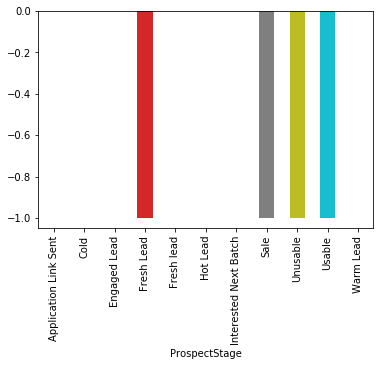

In [408]:
lead_df['LeadAge'] = lead_df['LeadAge'].map({'true': -1}) 
lead_df['LeadAge'] = pd.to_numeric(lead_df['LeadAge'] )
grouped_data = lead_df['LeadAge'].groupby([lead_df["ProspectStage"]]).mean()
grouped_data.plot(kind='bar')

[None '9+years' '0-3' '0-3_years' '3-6_years' '9+_yrs' '_0_-_3_years'
 '6-8_years_' '6-9_years' '9+_years' '5-8_years' '0-5_years' '3-5_years'
 '9+' '3-6_yrs' '3-6' '0-3_yrs' '2' '3' '4' '6-9' '6-9_yrs' '8'
 '2.5 years' '5yrs' '9+ years' '3-6 years' '11 yrs' '0-3 years'
 '3-5 years' '0 - 3 years' '8 yrs' '6-8 years' '6-9 years' '10' '7' '18'
 '1' '12+years' '5.5yrs' '5' '10 yrs' '6.7' '0']


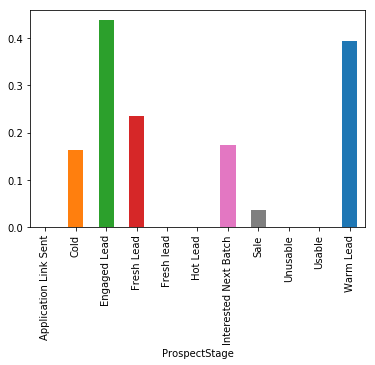

In [409]:
print(lead_df['mx_Experience_in_Years'].unique())
lead_df['mx_Experience_in_Years'] = lead_df['mx_Experience_in_Years'].map({
    None:0, '9+years':10, '0-3': 1.5, '0-3_years': 1.5, '3-6_years': 4.5, '9+_yrs': 10,
    '_0_-_3_years': 1.5, '6-8_years_': 7, '6-9_years': 7.5, '9+_years':10,
    '5-8_years': 6.5, '0-5_years': 2.5, '3-5_years': 4, '9+':10,
    '3-6_yrs': 4.5, '3-6': 4.5, '0-3_yrs': 1.5, '2': 2, '3':3, '4':4, '6-9': 7.5,
    '6-9_yrs': 7.5, '8':8, '2.5 years': 2.5, '5yrs': 5, '9+ years': 10, '3-6 years':4.5,
    '11 yrs': 11, '0-3 years':1.5, '3-5 years': 4.5, '0 - 3 years':1.5, '8 yrs':8,
    '6-8 years': 7, '6-9 years': 8.5, '10': 10, '7': 7, '18':18, '1': 1,
    '12+years': 13, '5.5yrs': 5.5, '5': 5, '10 yrs': 10, '6.7': 6.7, '0':0})
lead_df['mx_Experience_in_Years'] = pd.to_numeric(lead_df['mx_Experience_in_Years'] )
grouped_data = lead_df['mx_Experience_in_Years'].groupby([lead_df["ProspectStage"]]).mean()
grouped_data.plot(kind='bar')

lead_engagement_fields = ['ProspectActivityDate_Min', 'Web_Referrer', 'Web_RefKeyword','ConversionReferrerURL', 'SourceReferrerURL', 'SourceIPAddress','ProspectActivityId_Max', 'ProspectActivityId_Min', 'LastVisitDate', 'RelatedLandingPageId', 'FirstLandingPageSubmissionId', 'FirstLandingPageSubmissionDate', 'ProspectActivityName_Max', 'ProspectActivityDate_Max', 'Score', 'EngagementScore','ProspectStage', 'QualityScore01','TotalVisits', 'PageViewsPerVisit', 'AvgTimePerVisit','DoNotTrack', 'DoNotEmail', 'DoNotCall','OptInDate','LastOptInEmailSentDate','CurrentOptInStatus', 'StatusCode', 'StatusReason', 'DeletionStatusCode', 'Source', 'SourceCampaign', 'SourceMedium', 'SourceContent', 'mx_UTM_Term', 'mx_Browser', 'mx_Device_Info', 'mx_Preferred_Time_From', 'mx_Preferred_Time_To','mx_CallBack_Date_Time', 'MailingPreferences', 'OptInDetails', 'Origin']

lead_management_fields = ['LeadLastModifiedOn', 'RelatedProspectId', 'SourceReferrer', 'NotableEvent', 'NotableEventdate','mx_Application_Reference_ID','mx_Destination_Product', 'Revenue',  'OwnerId', 'CreatedBy', 'CreatedByName', 'CreatedOn', 'LeadConversionDate', 'ModifiedBy', 'ModifiedByName', 'ModifiedOn', 'TimeZone',  'OwnerIdName', 'OwnerIdEmailAddress','mx_BU', 'mx_SBU','mx_Center_Name','mx_Lead_Type', 'mx_Destination_SBU', 'IsStarredLead', 'IsTaggedLead', 'CanUpdate', 'Total', 'LeadAge','mx_Channel', 'mx_Flow','Groups', Notes', 'mx_Expected_Joining_Date',    'mx_Category', 'mx_Product_Category', 'mx_Product', 'mx_Expected_Joining',  'mx_Product_Group',  'mx_Admission_Number', 'mx_Campaign_ID',  'mx_Course_Alt', 'mx_Application_Link',  'mx_Chat_Link']

lead_info_fields = ['Latitude', 'Longitude', 'ProspectID', 'ProspectAutoId','FirstName', 'LastName', 'EmailAddress', 'Website','Phone', 'Company','TwitterId', 'PhotoUrl', 'FacebookId', 'LinkedInId', 'SkypeId', 'GTalkId', 'GooglePlusId',  'mx_Alternate_Email','mx_Street1', 'mx_Street2', 'mx_City', 'mx_State', 'mx_Country', 'mx_Zip', 'mx_Industry', 'mx_Gender',  'mx_Date_of_Birth', 'mx_Employee_ID', 'mx_Highest_Qulaification', 'mx_Years_of_Experience', 'mx_Salary', 'mx_Function_Area', 'mx_Division','mx_Lead_ID','Mobile','JobTitle', 'mx_Experience_in_Years', 'mx_Alternate_Phone_Number', 'mx_Age'] 

In [410]:
print(lead_df['DoNotTrack'].unique())
print(lead_df['DoNotEmail'].unique())
print(lead_df['DoNotCall'].unique())
print(lead_df['MailingPreferences'].unique())


[None]
['0' '1']
['0']
[None]


In [411]:
#lead_df.iloc['ConversionReferrerURL' == ]
print(lead_df['ConversionReferrerURL'].unique())

[None
 'https://r.search.yahoo.com/_ylt=AwrPhS2DO09b0GgAcxe7HAx.;_ylu=X3oDMTBycWJpM21vBGNvbG8Dc2czBHBvcwMxBHZ0aWQDBHNlYwNzcg--/RV=2/RE=1531948035/RO=10/RU=https://acadgild.com/blog/back-end-development-tools/RK=2/RS=V1MhqpPl8ZoHrdhdSXgJE1WgxAU-'
 'http://m.facebook.com/'
 'https://tpc.googlesyndication.com/safeframe/1-0-29/html/container.html?n=1'
 'android-app://com.google.android.gm'
 'https://www-hindexam-in.cdn.ampproject.org/v/www.hindexam.in/rajasthan-university-ba-3rd-year-time-table-2015/249.html/amp?usqp=mq331AQGCAEoATgB&amp_js_v=0.1'
 'https://googleads.g.doubleclick.net/pagead/ads?client=ca-pub-1792973056979970&output=html&h=280&slotname=4074844844&adk=338645475&adf=2019090055&w=360&fwrnh=101&lmt=1530731949&loeid=10583695&pucrd=CgwIABAAGAMgACgAOAESAhgHeAM&rafmt=1&guci=2.2.0.0.2.2.0&format=360x280&url=https://www.sarkariexam.com/bihar-bpsc-cdpo-admit-card/309198&flash=0&fwr=1&rh=0&rw=352.797&resp_fmts=3&sfro=1&wgl=1&adsid=AOsWmdeV8vdV8rH_gyjipmUee_rvs8DEDckJOdCsxxPlDUykEdsKB0

In [412]:
print(lead_df['Web_Referrer'].unique())

[None 'googleweblight.com' 'instagram.com' 'www.youtube.com'
 'www.google.com' 'www.google.co.in' 'm.facebook.com'
 'com.google.android.gm' 'l.facebook.com'
 'com.google.android.googlequicksearchbox' 'www.google.ca'
 'www.googleadservices.com' 'cn.bing.com' 'googleads.g.doubleclick.net'
 'acadgild.viewpage.co' 'app.vccedge.com' 'lm.facebook.com'
 'www.facebook.com' 'www.google.com.ng' 'r.search.yahoo.com'
 'webmail.musicmania.in' 'www.bing.com'
 'www-hindexam-in.cdn.ampproject.org' 'www.freepressjournal.in'
 'www.quora.com' 'marketing.susu-sahoo.com' 'tpc.googlesyndication.com'
 'youtube.com' 'acadgild.com' 'int.search.myway.com' 'mail.yahoo.com']


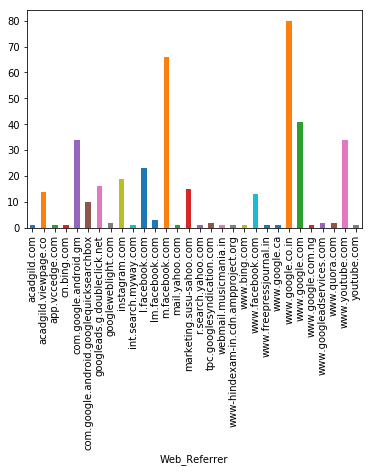

In [413]:

grouped_data = lead_df['ProspectID'].groupby([lead_df["Web_Referrer"]]).count()

grouped_data.plot(kind='bar')

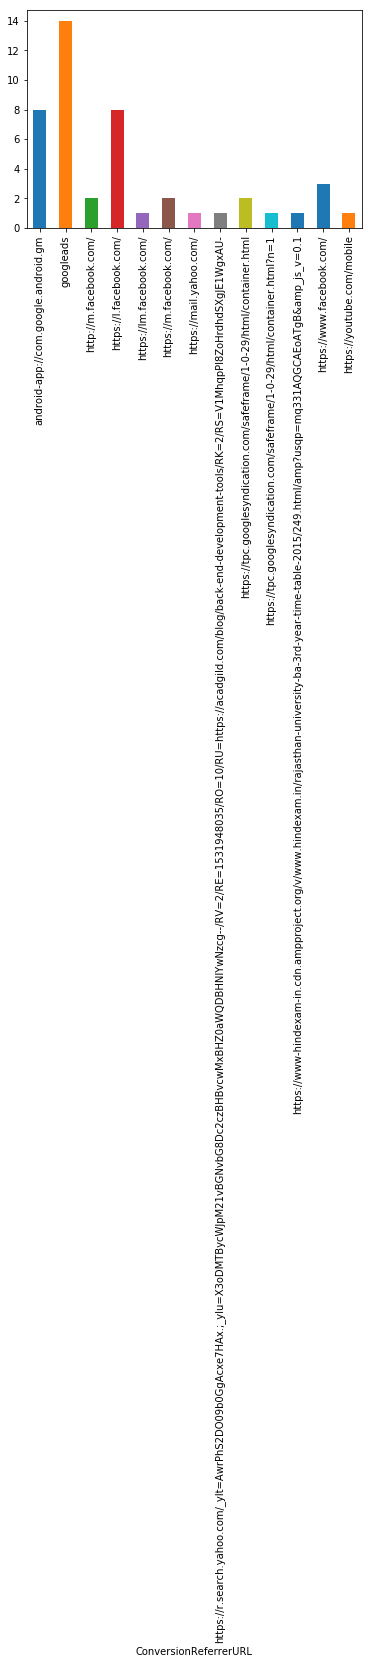

In [414]:
lead_df['ConversionReferrerURL'] = lead_df['ConversionReferrerURL'].replace({'(https:\/\/googleads(.*))' : 'googleads'}, regex=True)
grouped_data = lead_df['ProspectID'].groupby([lead_df["ConversionReferrerURL"]]).count()

grouped_data.plot(kind='bar')



In [415]:
print(lead_df['SourceReferrerURL'].unique())

[None
 'https://acadgild.viewpage.co/DS_Bootcamp_Event?utm_source=sms&utm_medium=event&utm_campaign=Seminar_DS_28July'
 'https://googleweblight.com/' 'http://instagram.com/'
 'https://www.youtube.com/' 'http://www.google.com/'
 'https://www.google.co.in/' 'http://m.facebook.com/'
 'android-app://com.google.android.gm'
 'http://acadgild.viewpage.co/DS_Bootcamp_Event?utm_source=onesignal&utm_medium=webpush&utm_campaign=Seminar_28Jul'
 'https://l.facebook.com/'
 'https://acadgild.viewpage.co/DAM-webinar?utm_source=email&utm_medium=drip&utm_campaign=webinar-DAM'
 'https://acadgild.viewpage.co/DS-Seminar?utm_source=drip&utm_medium=email&utm_campaign=DS_Seminar'
 'https://www.google.com/'
 'android-app://com.google.android.googlequicksearchbox'
 'http://l.facebook.com/l.php?u=http%3A%2F%2Fwww.acadgild.com%2F&h=AT0cGmg0I0StVbNuYzS4_ajKapdaYcNI7YegDhA6AC4DNDs1U-PatKtx8Sx5nFaactOkqC-z8TiS2wXOOXJjSlWDtgu1kmL-iEQbTcZRarBro454jxVbHrAF54KYuGODJtBV'
 'https://acadgild.viewpage.co/DS_Bootcamp_Event?u

In [416]:
print(lead_df['StatusCode'].unique())
print(lead_df['StatusReason'].unique())
print(lead_df['DeletionStatusCode'].unique())
print(lead_df['RelatedProspectId'].unique())
print(lead_df['SourceReferrer'].unique())
print(lead_df['TotalVisits'].unique())

['0' '1']
['0' '6' '5']
['0']
[None]
[None 'Google Ads' 'https://acadgild.com/customers/reviews' 'acadgild'
 'https://acadgild.com']
[None '0' '4' '2' '1' '9' '10' '3' '5' '31' '12' '7' '6' '38' '15' '25'
 '8' '11' '13' '33' '19' '16' '80' '30' '43' '17' '28' '39' '58' '59' '14'
 '69' '26' '64']


Combining all the score fields and dropping the individual ones

In [417]:
lead_df['Total_Score'] = lead_df['Score'] + lead_df['EngagementScore'] + lead_df['QualityScore01']


In [420]:
lead_df = lead_df.fillna(0)
lead_df['Source'] = lead_df["Source"].astype('category')
lead_df['Source'] = lead_df['Source'].cat.codes
print(lead_df['Source'].unique())
lead_df['mx_Highest_Qulaification'] = lead_df['mx_Highest_Qulaification'].astype('category')
lead_df['mx_Highest_Qulaification'] = lead_df['mx_Highest_Qulaification'].cat.codes
print(lead_df['mx_Highest_Qulaification'].unique())
#lead_df['mx_Years_of_Experience'] = lead_df["mx_Years_of_Experience"].astype('category')
#lead_df['mx_Years_of_Experience'] = lead_df['mx_Years_of_Experience'].cat.codes
lead_df['mx_Years_of_Experience'] = pd.to_numeric(lead_df['mx_Years_of_Experience'])
print(lead_df['mx_Years_of_Experience'].unique())
lead_df['mx_Flow'] = lead_df["mx_Flow"].astype('category')
lead_df['mx_Flow'] = lead_df['mx_Flow'].cat.codes
print(lead_df['mx_Flow'].unique())
lead_df['mx_Product_Category'] = lead_df['mx_Product_Category'].astype('category')
lead_df['mx_Product_Category'] = lead_df['mx_Product_Category'].cat.codes
print(lead_df['mx_Product_Category'].unique())

[ 18   2  46  19  86 163  14  32  84  80  10 166  37   7  48  25  20   5
  72  31  28  47  90 172  40  22   4  77 116  71 139  39  42  78  69  88
 117 112 111  51   0  50 160  33  82  29  62  53  11 143 137  59 110  64
  94 170 167 131 134 146  52 106 142 126  63  70  55  56  44  79   8  87
  58  61  45 164  41 107 161 145   9 157 159  74  75  24  83 155 153 156
  12  89 104  30  54 125  92  17   3 154 120  16 109 127  36 136 133 135
  60  91 105 158 121  85 115 108 168  73 152 151 171   1  23 113 118 140
  34  49  13  76 138 101  15  96 144  27 103  97  99 102 100   6  98 141
 123  43  81 114 122  93 130  65 169  38 162  68  26 165  66  67  57 148
 124 129  21 149 119 150 128 132 147  95  35]
[50  0 65 45 62 24 29 59 34 33 66 53 57 60 12 10 55 27 52 63 20 11 31 56
 58 43 61 25  9 32 22 47 48 21  6 64 51 23 44 67 19  4 38 37 14  3 13 28
 36 42  7 15 16  2  1 41 39 30  5 54 40 18 17  8 46 26 49 35]
[ 3.  0. 16. 11.  2.  8.  6.  9.  5. 14.  1. 13.  4. 10. 12. 18. 20. 17.
 15. 30.  7. 21.

In [421]:
lead_df['mx_Salary'] = pd.to_numeric(lead_df['mx_Salary'])
lead_df['mx_Experience_in_Years'] = pd.to_numeric(lead_df['mx_Experience_in_Years'])
lead_df['mx_Age'] = pd.to_numeric(lead_df['mx_Age'])

In [422]:
lead_df['mx_Lead_Type'] = lead_df['mx_Lead_Type'].astype('category')
lead_df['mx_Lead_Type'] = lead_df['mx_Lead_Type'].cat.codes
print(lead_df['mx_Lead_Type'].unique())

lead_df['ProspectStage'] = lead_df['ProspectStage'].astype('category')
lead_df['ProspectStage'] = lead_df['ProspectStage'].cat.codes
print(lead_df['ProspectStage'].unique())

[0 7 3 9 5 2 8 6 1 4]
[ 2  1 10  3  7  6  0  4  5  8  9]


In [423]:
X = lead_df[['Source', 'Total_Score', 'mx_Highest_Qulaification', 'mx_Years_of_Experience', 'mx_Flow',\
            'mx_Product_Category', 'mx_Salary', 'mx_Lead_Type', 'mx_Experience_in_Years', 'mx_Age']]
Y = lead_df['ProspectStage']

In [425]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
train_x, test_x, train_lbl, test_lbl = train_test_split(
    X, Y, test_size=0.3, random_state=122)
model = LogisticRegression()
model.fit(train_x, train_lbl)
y_pred = model.predict(test_x)
count_misclassified = (test_lbl != y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(test_lbl, y_pred)
print('Accuracy: {:.2f}'.format(accuracy))

Misclassified samples: 2299
Accuracy: 0.90


In [430]:
random_forest_model = RandomForestClassifier(random_state=1)
random_forest_model.fit(train_x, train_lbl)
y_pred = random_forest_model.predict(test_x)
count_misclassified = (test_lbl != y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(test_lbl, y_pred)
print('Accuracy: {:.2f}'.format(accuracy))

Misclassified samples: 1763
Accuracy: 0.92
